In [218]:
%matplotlib inline
import sys, os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['THEANO_FLAGS'] = 'device=cpu,compiledir_format="ipynb_compiledir_%(platform)s-%(processor)s-%(python_version)s-%(python_bitwidth)s"'
sys.path.append(os.getcwd()+"/..")

from tasks import check as load_filename
from scripts.imgtovideo import imgs_to_video
from data import load_data
from helpers import salt_and_pepper

import matplotlib.pyplot as plt
import numpy as np

import theano
import theano.tensor as T

from lasagne import layers as L

from lasagnekit.misc.plot_weights import dispims_color, tile_raster_images

from IPython.display import HTML, Image

import pandas as pd

from tqdm import tqdm

import base64
import json

from skimage.io import imread, imsave
from skimage.transform import resize

def load_model(filename, **kw):

    model = load_filename(
        what="notebook", 
        filename=filename, 
        **kw
    )
    return model

def build_brush_func(layers):
    if 'biased_output' in layers:
        bias = layers['biased_output'].b.get_value()
    elif 'bias' in layers:
        bias = layers['bias'].b.get_value()
    else:
        bias = np.array(0.1)

    bias = bias[np.newaxis, np.newaxis, :, np.newaxis, np.newaxis]

    if 'scaled_output' in layers:
        scale = layers['scaled_output'].scales.get_value()
    elif 'scale' in layers:
        scale = layers['scale'].scales.get_value()
    else:
        scale = np.array((1.,))
    scale = scale[np.newaxis, np.newaxis, :, np.newaxis, np.newaxis]

    
    X = T.tensor4()

    B = L.get_output(layers['brush'], X)
    if len(layers['brush'].output_shape) == 4: # (ex, t, w, h)
        B = B.dimshuffle(0, 1, 'x', 2, 3)
    
    fn = theano.function(
        [X], 
        T.nnet.sigmoid(B * scale + bias)
    )
    return fn

def build_encode_func(layers):
    w = layers['output'].output_shape[2]
    X = T.tensor4()
    fn = theano.function(
        [X], 
        T.nnet.sigmoid(L.get_output(layers['coord'], X)[:, :, 0:2]) * w
    )
    return fn

def to_grid_of_images(seq_imgs, **kw):
    y = seq_imgs
    imgs = []
    for t in range(y.shape[1]):
        yy = y[:, t]
        if yy.shape[1] == 1:
            yy = yy[:, 0, :, :, np.newaxis] * np.ones((1, 1, 1, 3))
        else:
            yy = yy.transpose((0, 2, 3, 1))
        img = dispims_color(yy, **kw)
        imgs.append(img)
    return imgs

def seq_to_video(seq, filename='out.mp4', verbose=1, framerate=8, rate=8, **kw):
    # shape of seq should be : (examples, time, c, w, h)
    seq = to_grid_of_images(seq, **kw)
    seq = [np.zeros_like(seq[0])] + seq
    if os.path.exists(filename):
        os.remove(filename)
    imgs_to_video(seq, out=filename, verbose=verbose, framerate=framerate, rate=rate)

def embed_video(filename):
    video = open(filename, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded.decode('ascii')))
def disp_grid(imgs, **kw):
    # shape of imgs should be : (examples, color, w, h)
    out = dispims_color(imgs.transpose((0, 2, 3, 1)) * np.ones((1, 1, 1, 3)), **kw)
    return out

In [127]:
model_a, data, layers, w, h, c = load_model("../training/fractal/a/model.pkl", 
                                            dataset="rescaled_digits", 
                                            force_w=16, force_h=16)

Loading data...


INFO:tasks:Loading data...


Loading the model...


INFO:tasks:Loading the model...


(None, 1, 16, 16)
Compiling the model...


INFO:tasks:Compiling the model...


{'patience_stat': 'avg_loss_train_fix', 'epsilon': 1e-08, 'max_nb_epochs': 100000, 'batch_size': 128, 'initial_lr': 0.1, 'patience_nb_epochs': 800, 'lr_decay_method': 'none', 'beta2': 0.95, 'beta1': 0.95, 'min_nb_epochs': 100000, 'lr_decay': 0, 'momentum': 0.9, 'algo': 'adadelta'}
autoencoder


In [105]:
model_b, data, layers, w, h, c = load_model("../training/fractal/b/model.pkl", 
                                            dataset="random_cropped_digits", 
                                            force_w=8, force_h=8)

Loading data...


INFO:tasks:Loading data...


(0, 128, (128000, 64))
loaded
(128, 128, (128000, 64))
Loading the model...


INFO:tasks:Loading the model...


(None, 1, 8, 8)
Compiling the model...


INFO:tasks:Compiling the model...


{'patience_stat': 'avg_loss_train_fix', 'epsilon': 1e-08, 'max_nb_epochs': 100000, 'batch_size': 128, 'initial_lr': 0.1, 'patience_nb_epochs': 800, 'lr_decay_method': 'none', 'beta2': 0.95, 'beta1': 0.95, 'min_nb_epochs': 100000, 'lr_decay': 0, 'momentum': 0.9, 'algo': 'adadelta'}
autoencoder


In [128]:
def downscale(x, scale=2):
    h, w = x.shape
    x = x.reshape((h / scale, scale, w / scale, scale))
    return x.mean(axis=(1, 3)), (x - x.mean(axis=(1, 3), keepdims=True)).reshape((h, w))

def upscale(x, r):
    shape = r.shape
    y_scale = r.shape[0] / x.shape[0]
    x_scale = r.shape[1] / x.shape[1]        
    r = r.reshape((r.shape[0] / y_scale, y_scale, r.shape[1] / x_scale, x_scale))
    x = x.reshape((x.shape[0], 1, x.shape[1], 1))
    return (x + r).reshape(shape)

In [234]:
print(len(imgs))

20


In [287]:
from IPython import display
from skimage.transform import resize
sw, sh = 8, 8
scale = 2
imgs = []
np.random.seed(2)
for K in range(100):
    x = np.random.uniform(0, 1, size=(32, 32))#>0.01
    for i in range(200):
        x_new, resid = downscale(x, scale=scale)
        x_new = x_new[np.newaxis, np.newaxis, :, :]
        x_new = x_new.astype(np.float32)

        if i % 20 == 0 and i > 0:
            for _ in range(10):
                x_new = model_a.reconstruct(x_new)
                x_new = x_new > 0.38
        
        x_new = x_new[0, 0]
        x_new = upscale(x_new, resid)
        x  = x_new
        x = x > 0.38

        py = np.random.randint(0, x.shape[0] - sh)
        px = np.random.randint(0, x.shape[0] - sw)
        patch = x[py:py+sh, px:px+sw]#.copy()
        #print(x.shape, patch.shape)
        patch = patch[np.newaxis, np.newaxis, :, :]
        patch = patch.astype(np.float32)

        for _ in range(5):
            patch = model_b.reconstruct(patch)
            patch = patch > 0.6
        x[py:py+sh, px:px+sw] = patch[0, 0]
        x = x > 0.6
        #display.clear_output(wait=True)
        #plt.imshow(x, cmap='gray', interpolation='none')
        #display.display(plt.gcf())
    imgs.append(x)
#display.clear_output(wait=True)

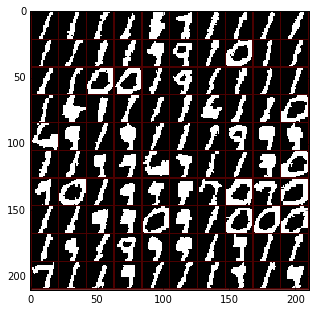

In [290]:
imgs_ = [im[6:-6, 6:-6] for im in imgs]
fig = plt.figure(figsize=(5, 5))
plt.imshow(disp_grid(np.array(imgs_)[:, None, :, :], border=1, bordercolor=(0.3, 0, 0)), interpolation='none')

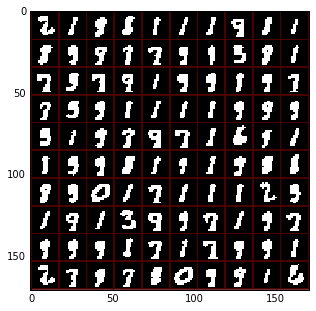

In [289]:
from skimage.transform import rescale
x = np.random.uniform(size=(100, 1, 16, 16)).astype(np.float32)
iters = []
for i in range(20):
    #x = salt_and_pepper(x, backend='numpy', corruption_level=0.5)
    x  = model_a.reconstruct(x)
    x = x>0.38
    iters.append(x)
x = x.transpose((0, 2, 3, 1)) * np.ones((1, 1, 1, 3))
img = dispims_color(x, border=1, bordercolor=(0.3, 0.0, 0.0))
#img = rescale(img, 2)
#img = img > 0.38
fig = plt.figure(figsize=(5, 5))
plt.imshow(img, interpolation='none')

In [281]:
!rm out.mp4
iters = map(disp_grid, iters)
imgs_to_video(iters, out='out.mp4', verbose=1, framerate=8, rate=8)
embed_video('out.mp4')

ffmpeg -framerate 8 -i img%08d.png -c:v libx264 -r 8 -pix_fmt yuv420p /home/mcherti/work/code/feature_generation/ipynb/out.mp4


In [282]:
h = x.reshape((x.shape[0], -1))
def hash_array(x):
    return hash(tuple(x))
h = map(hash_array, h)
len(set(h)) / float(len(x))

0.72